# Parsing

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

file_path = "/Users/leoss/Desktop/base_dataset.xlsx"

all_data = []
all_excluded = []  # Track all excluded rows

def track_exclusion(df, reason, sheet_name, resource, metric):
    """Helper to track excluded rows with metadata"""
    if len(df) > 0:
        excluded = df.copy()
        excluded['_exclusion_reason'] = reason
        excluded['_sheet'] = sheet_name
        excluded['_resource'] = resource
        excluded['_metric'] = metric
        all_excluded.append(excluded)
        return len(df)
    return 0

# ============================================================
# SIMPLE PARSER WITH EXCLUSION TRACKING
# ============================================================
def parse_simple(sheet_name, resource, metric, skip_rows=2):
    df = pd.read_excel(
        file_path, 
        sheet_name=sheet_name, 
        skiprows=skip_rows,
        keep_default_na=False,
        na_values=['']
    )
    
    first_col = df.columns[0]
    df = df.rename(columns={first_col: 'Country'})
    
    year_cols = [c for c in df.columns if isinstance(c, (int, float)) and 1800 < c < 2030]
    df = df[['Country'] + year_cols]
    
    # Track: Country is NA
    excluded_na = df[df['Country'].isna()]
    track_exclusion(excluded_na, 'Country is NA', sheet_name, resource, metric)
    df = df[df['Country'].notna()]
    
    # Track: Regex filter
    regex_pattern = r'Source|Note|Please|Less than|n/a|includes|Excludes|Commercial|Differences|Annual|methodology|^USSR'
    mask = df['Country'].astype(str).str.contains(regex_pattern, case=False, na=True, regex=True)
    excluded_regex = df[mask]
    track_exclusion(excluded_regex, f'Regex filter: {regex_pattern}', sheet_name, resource, metric)
    df = df[~mask]
    
    df_long = df.melt(id_vars='Country', var_name='Year', value_name='Value')
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
    df_long['Resource'] = resource
    df_long['Metric'] = metric
    
    # Track: dropna
    before_drop = len(df_long)
    excluded_dropna = df_long[df_long[['Year', 'Value', 'Country']].isna().any(axis=1)]
    track_exclusion(excluded_dropna, 'dropna (Year/Value/Country NA after melt)', sheet_name, resource, metric)
    
    return df_long.dropna(subset=['Year', 'Value', 'Country'])

# ============================================================
# MINERALS PARSER - EXTRACTS BOTH PRODUCTION AND RESERVES
# ============================================================
def parse_minerals(sheet_name, resource):
    df = pd.read_excel(
        file_path, 
        sheet_name=sheet_name, 
        skiprows=2,
        keep_default_na=False,
        na_values=['']
    )
    
    first_col = df.columns[0]
    df = df.rename(columns={first_col: 'Country'})
    
    # Debug: show all columns
    print(f"\n  DEBUG [{sheet_name}] All columns: {df.columns.tolist()}")
    
    # Get year columns for PRODUCTION
    year_cols = [c for c in df.columns if isinstance(c, (int, float)) and 1990 < c < 2030]
    
    # Find RESERVES column - look for "At end of" or column after the year columns
    reserves_col = None
    for col in df.columns:
        col_str = str(col).lower()
        if 'at end of' in col_str or 'reserves' in col_str:
            reserves_col = col
            break
    
    # If not found by name, try to find by position (typically after the last year column)
    if reserves_col is None:
        all_cols = df.columns.tolist()
        if year_cols:
            last_year_idx = all_cols.index(max(year_cols))
            # Look for numeric column after year columns (skip percentage columns)
            for i in range(last_year_idx + 1, min(last_year_idx + 5, len(all_cols))):
                potential_col = all_cols[i]
                # Check if this column has numeric data
                test_vals = pd.to_numeric(df[potential_col], errors='coerce')
                if test_vals.notna().sum() > 5:  # At least 5 valid numbers
                    # Skip if it looks like percentages (values mostly between -100 and 100)
                    valid_vals = test_vals.dropna()
                    if len(valid_vals) > 0 and valid_vals.abs().max() > 100:
                        reserves_col = potential_col
                        break
    
    print(f"  Year columns: {year_cols[:3]}...{year_cols[-3:] if len(year_cols) > 6 else ''}")
    print(f"  Reserves column found: {reserves_col}")
    
    if not year_cols:
        print(f"  WARNING: No year columns in {sheet_name}")
        return pd.DataFrame()
    
    # --- PRODUCTION DATA ---
    df_prod = df[['Country'] + year_cols].copy()
    
    # Track: Country is NA
    excluded_na = df_prod[df_prod['Country'].isna()]
    track_exclusion(excluded_na, 'Country is NA', sheet_name, resource, 'Production')
    df_prod = df_prod[df_prod['Country'].notna()]
    
    # Track: Regex filter
    regex_pattern = r'Source|Note|less than|Rest of World|Total World|^$|Mine|Thousand|n/a'
    mask = df_prod['Country'].astype(str).str.contains(regex_pattern, case=False, na=True, regex=True)
    excluded_regex = df_prod[mask]
    track_exclusion(excluded_regex, f'Regex filter: {regex_pattern}', sheet_name, resource, 'Production')
    df_prod = df_prod[~mask]
    
    df_prod_long = df_prod.melt(id_vars='Country', var_name='Year', value_name='Value')
    df_prod_long['Year'] = pd.to_numeric(df_prod_long['Year'], errors='coerce')
    df_prod_long['Value'] = pd.to_numeric(df_prod_long['Value'], errors='coerce')
    df_prod_long['Resource'] = resource
    df_prod_long['Metric'] = 'Production'
    
    # Track: dropna
    excluded_dropna = df_prod_long[df_prod_long[['Year', 'Value', 'Country']].isna().any(axis=1)]
    track_exclusion(excluded_dropna, 'dropna (Year/Value/Country NA after melt)', sheet_name, resource, 'Production')
    
    df_prod_long = df_prod_long.dropna(subset=['Year', 'Value', 'Country'])
    
    # --- RESERVES DATA ---
    df_reserves_long = pd.DataFrame()
    if reserves_col is not None:
        df_res = df[['Country', reserves_col]].copy()
        df_res.columns = ['Country', 'Value']
        
        # Apply same filters
        df_res = df_res[df_res['Country'].notna()]
        mask = df_res['Country'].astype(str).str.contains(regex_pattern, case=False, na=True, regex=True)
        df_res = df_res[~mask]
        
        df_res['Value'] = pd.to_numeric(df_res['Value'], errors='coerce')
        df_res = df_res.dropna(subset=['Value'])
        df_res = df_res[df_res['Value'] > 0]  # Only positive reserves
        
        df_res['Year'] = 2024  # "At end of 2024"
        df_res['Resource'] = resource
        df_res['Metric'] = 'Reserves'
        
        df_reserves_long = df_res
        print(f"  ✓ Extracted {len(df_reserves_long)} RESERVES rows for {resource}")
    else:
        print(f"  ⚠️  No reserves column found for {resource}")
    
    # Combine production and reserves
    result = pd.concat([df_prod_long, df_reserves_long], ignore_index=True)
    return result

# ============================================================
# RESERVES HISTORY PARSER WITH EXCLUSION TRACKING
# ============================================================
def parse_reserves_history(sheet_name, resource):
    df = pd.read_excel(
        file_path, 
        sheet_name=sheet_name, 
        skiprows=4,
        keep_default_na=False,  # Prevent "n/a" strings from becoming NaN
        na_values=['']          # Only treat empty cells as NA
    )
    
    first_col = df.columns[0]
    df = df.rename(columns={first_col: 'Country'})
    
    year_cols = [c for c in df.columns if isinstance(c, (int, float)) and 1800 < c < 2030]
    
    if not year_cols:
        print(f"  WARNING: No year columns in {sheet_name}")
        return pd.DataFrame()
    
    df = df[['Country'] + year_cols]
    
    # Track: Country is NA
    excluded_na = df[df['Country'].isna()]
    track_exclusion(excluded_na, 'Country is NA', sheet_name, resource, 'Reserves')
    df = df[df['Country'].notna()]
    
    # Track: Regex filter
    regex_pattern = r'Source|Note|Please|Less than|^$|methodology|Reserves-to|Total proved|^USSR|of which'
    mask = df['Country'].astype(str).str.contains(regex_pattern, case=False, na=True, regex=True)
    excluded_regex = df[mask]
    track_exclusion(excluded_regex, f'Regex filter: {regex_pattern}', sheet_name, resource, 'Reserves')
    df = df[~mask]
    
    df_long = df.melt(id_vars='Country', var_name='Year', value_name='Value')
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
    df_long['Resource'] = resource
    df_long['Metric'] = 'Reserves'
    
    # Track: dropna - only drop rows where Value is NaN
    excluded_dropna = df_long[df_long['Value'].isna()]
    track_exclusion(excluded_dropna, 'Value is NA after numeric conversion', sheet_name, resource, 'Reserves')
    
    result = df_long[df_long['Value'].notna()]
    return result

# ============================================================
# COAL RESERVES PARSER WITH EXCLUSION TRACKING
# ============================================================
def parse_coal_reserves():
    sheet_name = 'Coal - Reserves'
    df = pd.read_excel(
        file_path, 
        sheet_name=sheet_name, 
        skiprows=4,
        keep_default_na=False,
        na_values=['']
    )
    df = df.iloc[:, [0, 3]]
    df.columns = ['Country', 'Value']
    
    # Track: Country is NA
    excluded_na = df[df['Country'].isna()]
    track_exclusion(excluded_na, 'Country is NA', sheet_name, 'Coal', 'Reserves')
    df = df[df['Country'].notna()]
    
    # Track: Regex filter
    regex_pattern = r'Source|Note|Please|Less than|methodology'
    mask = df['Country'].astype(str).str.contains(regex_pattern, case=False, na=True, regex=True)
    excluded_regex = df[mask]
    track_exclusion(excluded_regex, f'Regex filter: {regex_pattern}', sheet_name, 'Coal', 'Reserves')
    df = df[~mask]
    
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    
    # Track: Value NA
    excluded_value_na = df[df['Value'].isna()]
    track_exclusion(excluded_value_na, 'Value is NA after numeric conversion', sheet_name, 'Coal', 'Reserves')
    df = df.dropna(subset=['Value'])
    
    df['Year'] = 2020
    df['Resource'] = 'Coal'
    df['Metric'] = 'Reserves'
    return df

# ============================================================
# OIL PRICES PARSER WITH EXCLUSION TRACKING
# ============================================================
def parse_oil_prices():
    sheet_name = 'Oil crude prices since 1861'
    df = pd.read_excel(
        file_path, 
        sheet_name=sheet_name, 
        skiprows=3,
        keep_default_na=False,
        na_values=['']
    )
    df = df.iloc[:, [0, 2]]
    df.columns = ['Year', 'Value']
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    
    # Track: dropna
    excluded_dropna = df[df.isna().any(axis=1)]
    track_exclusion(excluded_dropna, 'Year or Value is NA', sheet_name, 'Oil', 'Price')
    
    df = df.dropna()
    df['Country'] = 'Global'
    df['Resource'] = 'Oil'
    df['Metric'] = 'Price'
    return df

# ============================================================
# RUN ALL PARSERS
# ============================================================
print("="*60)
print("LOADING DATA - EXTRACTING BOTH PRODUCTION AND RESERVES")
print("="*60)

# --- Fossil fuel Production & Consumption ---
simple_sheets = [
    ('Oil Production - barrels', 'Oil', 'Production'),
    ('Oil Consumption - barrels', 'Oil', 'Consumption'),
    ('Gas Production - Bcm', 'Natural Gas', 'Production'),
    ('Gas Consumption - Bcm', 'Natural Gas', 'Consumption'),
    ('Coal Production - EJ', 'Coal', 'Production'),
    ('Coal Consumption - EJ', 'Coal', 'Consumption'),
]

for sheet, resource, metric in simple_sheets:
    try:
        df = parse_simple(sheet, resource, metric, skip_rows=2)
        all_data.append(df)
        print(f"✓ {sheet}: {len(df):,} rows")
    except Exception as e:
        print(f"✗ {sheet}: {e}")

# --- Reserves History (Oil & Gas) ---
for sheet, resource in [('Oil - Proved reserves history', 'Oil'), 
                        ('Gas - Proved reserves history', 'Natural Gas')]:
    try:
        df = parse_reserves_history(sheet, resource)
        all_data.append(df)
        print(f"✓ {sheet}: {len(df):,} rows")
    except Exception as e:
        print(f"✗ {sheet}: {e}")

# --- Minerals P-R (BOTH Production AND Reserves) ---
print("\n" + "="*60)
print("MINERALS - EXTRACTING PRODUCTION AND RESERVES")
print("="*60)

minerals = [
    ('Lithium P-R', 'Lithium'),
    ('Cobalt P-R', 'Cobalt'),
    ('Nickel P-R', 'Nickel'),
    ("Tin P-R", "Tin"),
    ("Bauxite P-R", "Bauxite"),
    ('Natural Graphite P-R', 'Natural Graphite'),
    ('Copper P-R', 'Copper'),
    ('Aluminium P-R', 'Aluminium'),
    ('Zinc P-R', 'Zinc'),
    ('Manganese P-R', 'Manganese'),
    ('Rare Earth metals P-R', 'Rare Earth'),
    ('Platinum Group Metals P-R', 'Platinum Group'),
    ('Vanadium P-R', 'Vanadium'),
]

for sheet, resource in minerals:
    try:
        df = parse_minerals(sheet, resource)
        all_data.append(df)
        prod_count = len(df[df['Metric'] == 'Production'])
        res_count = len(df[df['Metric'] == 'Reserves'])
        print(f"✓ {sheet}: {prod_count:,} Production + {res_count:,} Reserves = {len(df):,} total")
    except Exception as e:
        print(f"✗ {sheet}: {e}")

# --- Other ---
try:
    df = parse_coal_reserves()
    all_data.append(df)
    print(f"✓ Coal - Reserves: {len(df):,} rows")
except Exception as e:
    print(f"✗ Coal - Reserves: {e}")

try:
    df = parse_oil_prices()
    all_data.append(df)
    print(f"✓ Oil Prices: {len(df):,} rows")
except Exception as e:
    print(f"✗ Oil Prices: {e}")

# ============================================================
# COMBINE AND EXPORT
# ============================================================
df_combined = pd.concat(all_data, ignore_index=True)

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nTotal rows: {len(df_combined):,}")
print(f"\nBy Metric:")
print(df_combined['Metric'].value_counts())
print(f"\nReserves by Resource:")
reserves_df = df_combined[df_combined['Metric'] == 'Reserves']
print(reserves_df['Resource'].value_counts())

output_path = "/Users/leoss/Desktop/natural_resources_combined.csv"
df_combined.to_csv(output_path, index=False)
print(f"\n✓ Combined data exported to: {output_path}")

LOADING DATA - EXTRACTING BOTH PRODUCTION AND RESERVES
✓ Oil Production - barrels: 4,140 rows
✓ Oil Consumption - barrels: 6,120 rows
✓ Gas Production - Bcm: 3,630 rows
✓ Gas Consumption - Bcm: 6,120 rows
✓ Coal Production - EJ: 2,200 rows
✓ Coal Consumption - EJ: 6,120 rows
✓ Oil - Proved reserves history: 2,720 rows
✓ Gas - Proved reserves history: 2,634 rows

MINERALS - EXTRACTING PRODUCTION AND RESERVES

  DEBUG [Lithium P-R] All columns: ['Country', 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, '2024.1', '2014-24', '2024.2', 'Unnamed: 34', 'At end of 2024', 'Share', 'R/P ratio']
  Year columns: [1995, 1996, 1997]...[2022, 2023, 2024]
  Reserves column found: At end of 2024
  ✓ Extracted 8 RESERVES rows for Lithium
✓ Lithium P-R: 240 Production + 8 Reserves = 248 total

  DEBUG [Cobalt P-R] All columns: ['Country', 1995, 1996, 1997, 1998, 1999, 2000,

# Clustering

CLUSTERING BY PRODUCTION / GDP
HIGH CONCENTRATION = >15% RESERVES (ENERGY OR MINERALS)

[1] LOADING DATA
----------------------------------------
  Resource rows: 27,013
  Countries: 109

  Metrics in data:
Metric
Consumption    14040
Production      8942
Reserves        4031

  Resources with RESERVES data: ['Aluminium', 'Bauxite', 'Coal', 'Cobalt', 'Copper', 'Lithium', 'Manganese', 'Natural Gas', 'Natural Graphite', 'Nickel', 'Oil', 'Platinum Group', 'Rare Earth', 'Tin', 'Vanadium', 'Zinc']

  GDP countries: 142 (year 2021.0)

[2] PRODUCTION DATA (for clustering)
----------------------------------------
  Countries: 88
  Production features: ['Aluminium_Prod', 'Bauxite_Prod', 'Coal_Prod', 'Cobalt_Prod', 'Copper_Prod', 'Lithium_Prod', 'Manganese_Prod', 'Natural Gas_Prod', 'Natural Graphite_Prod', 'Nickel_Prod', 'Oil_Prod', 'Platinum Group_Prod', 'Rare Earth_Prod', 'Tin_Prod', 'Vanadium_Prod', 'Zinc_Prod']

[3] RESERVES DATA (for dominance)
----------------------------------------
  To

  ✓ Saved: clusters_high_concentration.html

[10] ADDITIONAL VISUALIZATIONS
----------------------------------------


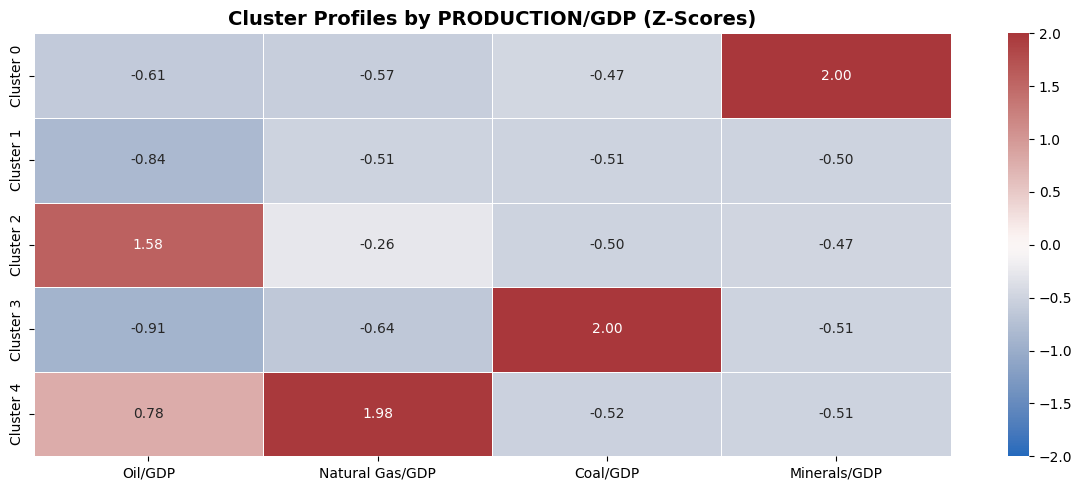


PCA Loadings:
                           PC1    PC2
Oil_Prod_perGDP          0.643 -0.114
Natural Gas_Prod_perGDP  0.670  0.081
Coal_Prod_perGDP        -0.220  0.767
Minerals_Prod_perGDP    -0.300 -0.627


In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION
# ============================================================
CONFIG = {
    'data_paths': {
        'resources': "/Users/leoss/Desktop/natural_resources_combined.csv",
        'gdp': "/Users/leoss/Desktop/Capstone/Code/Data/comprehensive_dataset.csv",
    },
    'output_dir': "/Users/leoss/Desktop/",
    'n_clusters': 5,
    'random_state': 42,
    'dominance_threshold': 15.0,  # % of global RESERVES to flag as dominant
    'impute_missing_production': True,
}

# ============================================================
# COUNTRY CODE MAPPING
# ============================================================
COUNTRY_TO_CODE = {
    'US': 'USA', 'United States': 'USA', 'USA': 'USA',
    'Canada': 'CAN', 'Mexico': 'MEX',
    'Brazil': 'BRA', 'Argentina': 'ARG', 'Chile': 'CHL', 
    'Peru': 'PER', 'Colombia': 'COL', 'Venezuela': 'VEN', 'Ecuador': 'ECU', 
    'Bolivia': 'BOL', 'Paraguay': 'PRY', 'Uruguay': 'URY', 'Guyana': 'GUY', 
    'Suriname': 'SUR', 'Trinidad & Tobago': 'TTO', 'Trinidad and Tobago': 'TTO',
    'Cuba': 'CUB', 'Dominican Republic': 'DOM', 'Jamaica': 'JAM',
    'Haiti': 'HTI', 'Panama': 'PAN', 'Costa Rica': 'CRI', 'Guatemala': 'GTM',
    'Honduras': 'HND', 'El Salvador': 'SLV', 'Nicaragua': 'NIC',
    'UK': 'GBR', 'United Kingdom': 'GBR', 'Germany': 'DEU', 'France': 'FRA',
    'Italy': 'ITA', 'Spain': 'ESP', 'Netherlands': 'NLD',
    'Belgium': 'BEL', 'Norway': 'NOR', 'Sweden': 'SWE', 'Finland': 'FIN',
    'Denmark': 'DNK', 'Austria': 'AUT', 'Switzerland': 'CHE', 'Ireland': 'IRL',
    'Portugal': 'PRT', 'Greece': 'GRC',
    'Luxembourg': 'LUX', 'Iceland': 'ISL', 'Cyprus': 'CYP',
    'Poland': 'POL', 'Czech Republic': 'CZE', 'Czechia': 'CZE',
    'Romania': 'ROU', 'Hungary': 'HUN', 'Slovakia': 'SVK', 'Bulgaria': 'BGR',
    'Croatia': 'HRV', 'Slovenia': 'SVN', 'Serbia': 'SRB', 'Ukraine': 'UKR',
    'Belarus': 'BLR', 'Lithuania': 'LTU', 'Latvia': 'LVA', 'Estonia': 'EST',
    'North Macedonia': 'MKD',
    'Russia': 'RUS', 'Russian Federation': 'RUS',
    'Kazakhstan': 'KAZ', 'Uzbekistan': 'UZB', 'Turkmenistan': 'TKM', 
    'Tajikistan': 'TJK', 'Kyrgyzstan': 'KGZ', 
    'Azerbaijan': 'AZE', 'Georgia': 'GEO', 'Armenia': 'ARM',
    'China': 'CHN', 'China ': 'CHN', 'China Hong Kong SAR': 'HKG',
    'Japan': 'JPN', 
    'South Korea': 'KOR', 'Korea': 'KOR', 'Republic of Korea': 'KOR',
    'North Korea': 'PRK', 'Taiwan': 'TWN', 'Mongolia': 'MNG',
    'India': 'IND', 'Indonesia': 'IDN', 
    'Philippines': 'PHL', 'Vietnam': 'VNM', 'Viet Nam': 'VNM', 'Thailand': 'THA', 
    'Malaysia': 'MYS', 'Singapore': 'SGP', 'Myanmar': 'MMR', 'Burma': 'MMR', 
    'Cambodia': 'KHM', 'Bangladesh': 'BGD', 'Pakistan': 'PAK', 'Sri Lanka': 'LKA', 
    'Nepal': 'NPL', 'Afghanistan': 'AFG',
    'Brunei': 'BRN', 'Brunei Darussalam': 'BRN',
    'Iran': 'IRN', 'Iraq': 'IRQ', 'Saudi Arabia': 'SAU', 'UAE': 'ARE',
    'United Arab Emirates': 'ARE', 'Kuwait': 'KWT', 'Qatar': 'QAT', 'Oman': 'OMN',
    'Yemen': 'YEM', 'Jordan': 'JOR', 'Lebanon': 'LBN', 'Syria': 'SYR',
    'Israel': 'ISR', 'Turkey': 'TUR', 'Türkiye': 'TUR', 'Bahrain': 'BHR',
    'South Africa': 'ZAF', 'Nigeria': 'NGA', 'Egypt': 'EGY', 'Algeria': 'DZA',
    'Morocco': 'MAR', 'Tunisia': 'TUN', 'Libya': 'LBY', 'Sudan': 'SDN',
    'South Sudan': 'SSD', 'Ethiopia': 'ETH', 'Kenya': 'KEN', 'Tanzania': 'TZA', 
    'Uganda': 'UGA', 'Ghana': 'GHA', 'Ivory Coast': 'CIV', "Cote d'Ivoire": 'CIV', 
    'Senegal': 'SEN', 'Cameroon': 'CMR', 'Angola': 'AGO', 'Mozambique': 'MOZ', 
    'Zambia': 'ZMB', 'Zimbabwe': 'ZWE', 'Botswana': 'BWA', 'Namibia': 'NAM', 
    'Gabon': 'GAB', 'Congo': 'COG', 'Republic of Congo': 'COG', 'DR Congo': 'COD', 
    'Democratic Republic of Congo': 'COD', 'DRC': 'COD', 'Mali': 'MLI',
    'Burkina Faso': 'BFA', 'Niger': 'NER', 'Chad': 'TCD', 'Mauritania': 'MRT',
    'Madagascar': 'MDG', 'Malawi': 'MWI', 'Rwanda': 'RWA', 'Equatorial Guinea': 'GNQ',
    'Australia': 'AUS', 'Australia ': 'AUS', 'New Zealand': 'NZL',
    'Papua New Guinea': 'PNG', 'Fiji': 'FJI', 'New Caledonia': 'NCL',
}

COUNTRY_NAME_FIXES = {
    'Russian Federation': 'Russia',
    'Brazil1': 'Brazil',
    'India2': 'India',
    'Democratic Republic of Congo': 'DR Congo',
    'China ': 'China',
    'Australia ': 'Australia',
}

AGGREGATES_PATTERN = (
    r'Total|Other |OPEC|OECD|European Union|of which|CIS|Non-|World|Rest of|'
    r'Middle East|Asia Pacific|Africa|Europe|Americas|America|Global|'
    r'Orinoco Belt|Oil Sands|Central '
)

# Energy vs Mineral classification
ENERGY_RESOURCES = ['Oil', 'Natural Gas', 'Coal']

# ============================================================
# MAIN
# ============================================================

def main():
    print("="*60)
    print("CLUSTERING BY PRODUCTION / GDP")
    print("HIGH CONCENTRATION = >15% RESERVES (ENERGY OR MINERALS)")
    print("="*60)
    
    # -------------------------
    # 1. LOAD & CLEAN DATA
    # -------------------------
    print("\n[1] LOADING DATA")
    print("-"*40)
    
    df_raw = pd.read_csv(CONFIG['data_paths']['resources'])
    df_raw['Country'] = df_raw['Country'].str.strip()
    df_raw['Country'] = df_raw['Country'].replace(COUNTRY_NAME_FIXES)
    df_clean = df_raw[~df_raw['Country'].str.contains(AGGREGATES_PATTERN, case=False, na=False)]
    
    print(f"  Resource rows: {len(df_clean):,}")
    print(f"  Countries: {df_clean['Country'].nunique()}")
    
    # Show what metrics are available
    print(f"\n  Metrics in data:")
    print(df_clean['Metric'].value_counts().to_string())
    
    # Show what resources have reserves
    reserves_resources = df_clean[df_clean['Metric'] == 'Reserves']['Resource'].unique()
    print(f"\n  Resources with RESERVES data: {sorted(reserves_resources)}")
    
    # Load GDP
    df_gdp_raw = pd.read_csv(CONFIG['data_paths']['gdp'])
    gdp_year = df_gdp_raw['Year'].max()
    df_gdp_latest = df_gdp_raw[df_gdp_raw['Year'] == gdp_year].copy()
    df_gdp_wide = df_gdp_latest.pivot_table(
        index=['Country Code', 'Country Name'],
        columns='Series Name', values='Value', aggfunc='first'
    ).reset_index()
    
    if 'GDP (current US$)' in df_gdp_wide.columns:
        df_gdp = df_gdp_wide[['Country Code', 'Country Name', 'GDP (current US$)']].copy()
        df_gdp = df_gdp.rename(columns={'GDP (current US$)': 'GDP'})
        df_gdp = df_gdp[df_gdp['GDP'].notna() & (df_gdp['GDP'] > 0)]
        print(f"\n  GDP countries: {len(df_gdp)} (year {gdp_year})")
    else:
        print("  ERROR: GDP column not found!")
        return None, None
    
    # -------------------------
    # 2. CREATE PRODUCTION DATA (FOR CLUSTERING)
    # -------------------------
    print("\n[2] PRODUCTION DATA (for clustering)")
    print("-"*40)
    
    df_prod = df_clean[df_clean['Metric'] == 'Production'].copy()
    df_prod_latest = df_prod.sort_values('Year', ascending=False).groupby(['Country', 'Resource']).first().reset_index()
    
    df_prod_wide = df_prod_latest.pivot_table(
        index='Country', columns='Resource', values='Value', aggfunc='first'
    ).reset_index()
    
    # Rename columns to indicate production
    prod_cols = [c for c in df_prod_wide.columns if c != 'Country']
    df_prod_wide.columns = ['Country'] + [f'{c}_Prod' for c in prod_cols]
    
    print(f"  Countries: {len(df_prod_wide)}")
    print(f"  Production features: {[c for c in df_prod_wide.columns if c.endswith('_Prod')]}")
    
    # -------------------------
    # 3. CREATE RESERVES DATA (FOR DOMINANCE)
    # -------------------------
    print("\n[3] RESERVES DATA (for dominance)")
    print("-"*40)
    
    df_res = df_clean[df_clean['Metric'] == 'Reserves'].copy()
    
    # Get latest reserves for each country/resource
    df_res_latest = df_res.sort_values('Year', ascending=False).groupby(['Country', 'Resource']).first().reset_index()
    
    print(f"  Total reserves records: {len(df_res_latest)}")
    print(f"  Reserves by resource:")
    print(df_res_latest['Resource'].value_counts().to_string())
    
    # Pivot to wide format
    df_res_wide = df_res_latest.pivot_table(
        index='Country', columns='Resource', values='Value', aggfunc='first'
    ).reset_index()
    
    # Rename columns to indicate reserves
    res_cols = [c for c in df_res_wide.columns if c != 'Country']
    df_res_wide.columns = ['Country'] + [f'{c}_Res' for c in res_cols]
    
    reserves_features = [c for c in df_res_wide.columns if c.endswith('_Res')]
    print(f"\n  Countries with reserves: {len(df_res_wide)}")
    print(f"  Reserves columns: {reserves_features}")
    
    # -------------------------
    # 4. MERGE PRODUCTION & RESERVES & GDP
    # -------------------------
    print("\n[4] MERGING DATA")
    print("-"*40)
    
    # First merge production and reserves
    df_wide = df_prod_wide.merge(df_res_wide, on='Country', how='outer')
    print(f"  After prod+reserves merge: {len(df_wide)} countries")
    
    # Check reserves columns are present
    res_cols_in_wide = [c for c in df_wide.columns if c.endswith('_Res')]
    print(f"  Reserves columns in merged data: {res_cols_in_wide}")
    
    df_wide['Country Code'] = df_wide['Country'].map(COUNTRY_TO_CODE)
    
    # Merge GDP
    df_wide = df_wide.merge(df_gdp[['Country Code', 'GDP']], on='Country Code', how='left')
    
    # Filter to countries with GDP
    n_before = len(df_wide)
    df_wide = df_wide[df_wide['GDP'].notna() & (df_wide['GDP'] > 0)]
    print(f"  Countries with GDP: {len(df_wide)} (dropped {n_before - len(df_wide)} without GDP)")
    
    # -------------------------
    # 5. CALCULATE RESERVES SHARES & FLAG HIGH CONCENTRATION
    # -------------------------
    print("\n[5] RESERVES GLOBAL SHARES - HIGH CONCENTRATION DETECTION")
    print("-"*40)
    
    threshold = CONFIG['dominance_threshold']
    
    # Get all available reserves columns
    available_reserves = [c for c in df_wide.columns if c.endswith('_Res')]
    
    # Separate into energy and minerals
    energy_reserves = [c for c in available_reserves if any(e in c for e in ENERGY_RESOURCES)]
    mineral_reserves = [c for c in available_reserves if c not in energy_reserves]
    
    print(f"\n  ⚡ ENERGY reserves columns: {energy_reserves}")
    print(f"  🪨 MINERAL reserves columns: {mineral_reserves}")
    
    print(f"\n  {'Resource':<20} {'Global Reserves':<18} {'Top Holder':<20} {'Share'}")
    print(f"  {'-'*75}")
    
    # Calculate global shares for ALL reserves columns
    share_columns_created = []
    for feat in available_reserves:
        global_total = df_wide[feat].sum()
        if global_total > 0:
            share_col = f'{feat}_Share'
            df_wide[share_col] = (df_wide[feat] / global_total) * 100
            share_columns_created.append(share_col)
            
            top_idx = df_wide[feat].idxmax()
            top_country = df_wide.loc[top_idx, 'Country']
            top_share = df_wide.loc[top_idx, share_col]
            resource_name = feat.replace('_Res', '')
            
            # Emoji based on energy vs mineral
            if feat in energy_reserves:
                emoji = "⚡"
            else:
                emoji = "🪨"
            
            marker = "🔴" if top_share >= threshold else "  "
            print(f"{marker} {emoji} {resource_name:<18} {global_total:<18,.0f} {top_country:<20} {top_share:.1f}%")
    
    print(f"\n  Share columns created: {len(share_columns_created)}")
    
    # Flag countries with HIGH CONCENTRATION (>15%) in any resource
    dominant_list = []
    max_concentration = []
    dominant_resources = []
    for idx, row in df_wide.iterrows():
        dominated = []
        max_share = 0
        resources_dominated = []
        for feat in available_reserves:
            share_col = f'{feat}_Share'
            if share_col in df_wide.columns:
                share_val = row.get(share_col)
                if pd.notna(share_val):
                    if share_val > max_share:
                        max_share = share_val
                    if share_val >= threshold:
                        resource_name = feat.replace('_Res', '')
                        dominated.append(f"{resource_name} ({share_val:.1f}%)")
                        resources_dominated.append(resource_name)
        dominant_list.append(dominated)
        max_concentration.append(max_share)
        dominant_resources.append(resources_dominated)
    
    df_wide['Dominant_Reserves'] = dominant_list
    df_wide['Dominant_Resources'] = dominant_resources
    df_wide['Max_Concentration'] = max_concentration
    df_wide['Dominant_Count'] = df_wide['Dominant_Reserves'].apply(len)
    df_wide['Is_Dominant'] = df_wide['Dominant_Count'] > 0
    
    print(f"\n  🔴 HIGH CONCENTRATION (>{threshold}% of global reserves):")
    dominant_df = df_wide[df_wide['Is_Dominant']][['Country', 'Dominant_Reserves', 'Max_Concentration']].copy()
    dominant_df = dominant_df.sort_values('Max_Concentration', ascending=False)
    print(f"  Found {len(dominant_df)} countries with high concentration")
    for _, row in dominant_df.iterrows():
        print(f"    {row['Country']}: {', '.join(row['Dominant_Reserves'])}")
    
    # -------------------------
    # 6. SELECT CLUSTERING FEATURES (PRODUCTION / GDP)
    # -------------------------
    print("\n[6] CLUSTERING FEATURES (Production / GDP)")
    print("-"*40)
    
    # Base production features
    prod_features = ['Oil_Prod', 'Natural Gas_Prod', 'Coal_Prod']
    prod_features = [f for f in prod_features if f in df_wide.columns]
    
    # Aggregate mineral production
    mineral_prod_cols = [c for c in df_wide.columns if c.endswith('_Prod') 
                         and not any(x in c for x in ['Oil', 'Natural Gas', 'Coal'])]
    if mineral_prod_cols:
        df_wide['Minerals_Prod'] = df_wide[mineral_prod_cols].sum(axis=1, skipna=True)
        prod_features.append('Minerals_Prod')
    
    # Create Production / GDP features (GDP in billions)
    clustering_features = []
    for feat in prod_features:
        gdp_feat = f'{feat}_perGDP'
        df_wide[gdp_feat] = df_wide[feat] / (df_wide['GDP'] / 1e9)
        clustering_features.append(gdp_feat)
    
    print(f"  Base production: {prod_features}")
    print(f"  Clustering on: {clustering_features}")
    
    # Impute missing production values if enabled
    if CONFIG['impute_missing_production']:
        print(f"\n  ⚠️  Imputing missing/zero production with 0.001 for visualization")
        impute_cols = ['Oil_Prod', 'Natural Gas_Prod', 'Coal_Prod', 'Minerals_Prod']
        for col in impute_cols:
            if col in df_wide.columns:
                n_missing = df_wide[col].isna().sum()
                n_zero = (df_wide[col] == 0).sum()
                df_wide[col] = df_wide[col].fillna(0.001)
                df_wide.loc[df_wide[col] == 0, col] = 0.001
                print(f"    {col}: {n_missing} NaN + {n_zero} zeros -> 0.001")
        
        # Recalculate production/GDP features after imputation
        for feat in prod_features:
            gdp_feat = f'{feat}_perGDP'
            df_wide[gdp_feat] = df_wide[feat] / (df_wide['GDP'] / 1e9)
    
    # Show top countries by production intensity
    print(f"\n  Top 5 by Oil Production / GDP:")
    if 'Oil_Prod_perGDP' in df_wide.columns:
        top_oil = df_wide.nlargest(5, 'Oil_Prod_perGDP')[['Country', 'Oil_Prod', 'GDP', 'Oil_Prod_perGDP']]
        for _, r in top_oil.iterrows():
            print(f"    {r['Country']}: {r['Oil_Prod_perGDP']:.2f} (prod={r['Oil_Prod']:,.0f}, GDP=${r['GDP']/1e9:.0f}B)")
    
    # -------------------------
    # 7. PREPARE & CLUSTER
    # -------------------------
    print("\n[7] CLUSTERING")
    print("-"*40)
    
    # Keep countries with at least 1 production/GDP value
    df_cluster = df_wide.copy()
    df_cluster['n_valid'] = df_cluster[clustering_features].notna().sum(axis=1)
    df_cluster = df_cluster[df_cluster['n_valid'] >= 1]
    df_cluster[clustering_features] = df_cluster[clustering_features].fillna(0)
    
    print(f"  Countries: {len(df_cluster)}")
    
    X = df_cluster[clustering_features].values
    X_log = np.log1p(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_log)
    
    n_clusters = CONFIG['n_clusters']
    kmeans = KMeans(n_clusters=n_clusters, random_state=CONFIG['random_state'], n_init=50)
    df_cluster['cluster'] = kmeans.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, df_cluster['cluster'])
    print(f"  Silhouette: {sil:.3f}")
    print(f"\n  Distribution: {df_cluster['cluster'].value_counts().sort_index().to_dict()}")
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    df_cluster['PC1'] = pca_result[:, 0]
    df_cluster['PC2'] = pca_result[:, 1]
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=clustering_features)
    
    # -------------------------
    # 8. RESULTS
    # -------------------------
    print("\n[8] CLUSTER RESULTS")
    print("-"*40)
    
    for c in range(n_clusters):
        mask = df_cluster['cluster'] == c
        countries = df_cluster[mask]['Country'].tolist()
        dominant_countries = df_cluster[mask & df_cluster['Is_Dominant']]['Country'].tolist()
        
        print(f"\nCluster {c} ({len(countries)} countries):")
        print(f"  {', '.join(sorted(countries)[:10])}{'...' if len(countries) > 10 else ''}")
        
        if dominant_countries:
            print(f"  🔴 High concentration (>15%): {', '.join(dominant_countries)}")
        
        means = df_cluster[mask][clustering_features].mean()
        prod_strs = [f"{f.replace('_Prod_perGDP','')}: {means[f]:.2f}" for f in clustering_features if means[f] > 0]
        print(f"  Avg prod/GDP: {', '.join(prod_strs)}")
    
    # -------------------------
    # 9. CHOROPLETH WITH RED BORDER FOR HIGH CONCENTRATION
    # -------------------------
    print("\n[9] CREATING MAP")
    print("-"*40)
    
    df_map = df_cluster[df_cluster['Country Code'].notna()].copy()
    
    # Get all share columns for hover text
    share_cols = [c for c in df_map.columns if c.endswith('_Res_Share')]
    print(f"  Share columns for hover: {share_cols}")
    
    print(f"  Countries on map: {len(df_map)}")
    print(f"  High concentration (>15%): {df_map['Is_Dominant'].sum()}")
    if df_map['Is_Dominant'].sum() > 0:
        print(f"  Countries with red border:")
        for country in df_map[df_map['Is_Dominant']]['Country'].tolist():
            print(f"    🔴 {country}")
    
    # Build hover text dynamically
    hover_texts = []
    for idx, row in df_map.iterrows():
        lines = [f"<b>{row['Country']}</b>"]
        if row['Is_Dominant']:
            lines.append(f"🔴 HIGH CONCENTRATION (>{threshold}% reserves)")
            for dom in row['Dominant_Reserves']:
                lines.append(f"   • {dom}")
        lines.append(f"Cluster: {int(row['cluster'])}")
        lines.append(f"GDP: ${row['GDP']/1e9:,.0f}B")
        lines.append("")
        lines.append("<b>Production / GDP:</b>")
        for f in clustering_features:
            if pd.notna(row.get(f)) and row[f] > 0:
                name = f.replace('_Prod_perGDP', '')
                lines.append(f"  {name}: {row[f]:.2f}")
        
        # DYNAMICALLY show ALL available reserve shares
        lines.append("")
        lines.append("<b>Reserve Shares:</b>")
        
        # Sort share columns: energy first, then minerals alphabetically
        energy_share_cols = [c for c in share_cols if any(e in c for e in ENERGY_RESOURCES)]
        mineral_share_cols = [c for c in share_cols if c not in energy_share_cols]
        
        # Energy resources
        for share_col in sorted(energy_share_cols):
            val = row.get(share_col)
            if pd.notna(val) and val > 1:
                resource_name = share_col.replace('_Res_Share', '')
                if val >= threshold:
                    lines.append(f"🔴 <b>⚡{resource_name}: {val:.1f}%</b>")
                else:
                    lines.append(f"  ⚡{resource_name}: {val:.1f}%")
        
        # Minerals
        for share_col in sorted(mineral_share_cols):
            val = row.get(share_col)
            if pd.notna(val) and val > 1:
                resource_name = share_col.replace('_Res_Share', '')
                if val >= threshold:
                    lines.append(f"🔴 <b>🪨{resource_name}: {val:.1f}%</b>")
                else:
                    lines.append(f"  🪨{resource_name}: {val:.1f}%")
        
        hover_texts.append("<br>".join(lines))
    df_map['hover_text'] = hover_texts
    
    colors = px.colors.qualitative.Bold[:n_clusters]
    fig = go.Figure()
    
    # Non-dominant (white border)
    for cid in range(n_clusters):
        mask = (df_map['cluster'] == cid) & (~df_map['Is_Dominant'])
        subset = df_map[mask]
        if len(subset) > 0:
            fig.add_trace(go.Choropleth(
                locations=subset['Country Code'], z=[cid]*len(subset),
                colorscale=[[0, colors[cid]], [1, colors[cid]]],
                showscale=False, hovertext=subset['hover_text'], hoverinfo='text',
                name=f'Cluster {cid}',
                marker=dict(line=dict(color='white', width=0.5))
            ))
    
    # HIGH CONCENTRATION countries (THICK RED border)
    for cid in range(n_clusters):
        mask = (df_map['cluster'] == cid) & (df_map['Is_Dominant'])
        subset = df_map[mask]
        if len(subset) > 0:
            fig.add_trace(go.Choropleth(
                locations=subset['Country Code'], z=[cid]*len(subset),
                colorscale=[[0, colors[cid]], [1, colors[cid]]],
                showscale=False, hovertext=subset['hover_text'], hoverinfo='text',
                name=f'Cluster {cid} 🔴 >15%',
                marker=dict(line=dict(color='red', width=4))
            ))
    
    fig.update_geos(
        projection_type="winkel tripel",
        showcountries=True, countrycolor="lightgray",
        showcoastlines=True, coastlinecolor="darkgray",
        showocean=True, oceancolor="aliceblue",
        showland=True, landcolor="whitesmoke"
    )
    
    fig.update_layout(
        title=dict(
            text=f"Clustering by PRODUCTION/GDP (k={n_clusters})<br><sup>🔴 Red Border = >{threshold}% of global reserves (Energy OR Minerals)</sup>",
            x=0.5, font=dict(size=18)
        ),
        width=1200, height=700,
        legend=dict(orientation="h", yanchor="bottom", y=0.01, xanchor="center", x=0.5),
        margin=dict(l=0, r=0, t=80, b=0)
    )
    
    fig.add_annotation(
        x=0.02, y=0.02, xref='paper', yref='paper',
        text=f'🔴 RED BORDER = >{threshold}% of global reserves',
        showarrow=False, font=dict(size=12, color='red'),
        bgcolor='white', bordercolor='red', borderwidth=2, borderpad=4
    )
    
    fig.show()
    fig.write_html(f"{CONFIG['output_dir']}clusters_high_concentration.html")
    print(f"  ✓ Saved: clusters_high_concentration.html")
    
    # -------------------------
    # 10. HEATMAP & BIPLOT
    # -------------------------
    print("\n[10] ADDITIONAL VISUALIZATIONS")
    print("-"*40)
    
    # Heatmap
    centroids = df_cluster.groupby('cluster')[clustering_features].mean()
    centroid_z = pd.DataFrame(
        StandardScaler().fit_transform(centroids),
        index=[f'Cluster {i}' for i in centroids.index],
        columns=[f.replace('_Prod_perGDP', '/GDP') for f in clustering_features]
    )
    
    plt.figure(figsize=(12, 5))
    sns.heatmap(centroid_z, annot=True, cmap='vlag', fmt='.2f', linewidths=0.5, vmin=-2, vmax=2)
    plt.title('Cluster Profiles by PRODUCTION/GDP (Z-Scores)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Biplot
    df_plot = df_cluster.copy()
    df_plot['cluster'] = df_plot['cluster'].astype(str)
    
    fig_bi = px.scatter(
        df_plot, x='PC1', y='PC2', color='cluster',
        symbol='Is_Dominant', symbol_map={True: 'star', False: 'circle'},
        hover_name='Country',
        color_discrete_sequence=px.colors.qualitative.Bold,
    )
    fig_bi.update_traces(marker=dict(size=10), selector=dict(marker_symbol='circle'))
    fig_bi.update_traces(marker=dict(size=18, line=dict(width=2, color='darkred')), selector=dict(marker_symbol='star'))
    
    scale = 3
    for feat in clustering_features:
        fig_bi.add_annotation(
            ax=0, ay=0,
            x=loadings.loc[feat, 'PC1'] * scale,
            y=loadings.loc[feat, 'PC2'] * scale,
            showarrow=True, arrowhead=2, arrowwidth=2,
            text=feat.replace('_Prod_perGDP', '/GDP'),
            font=dict(size=10)
        )
    
    fig_bi.update_layout(
        title=f'PCA Biplot: Production/GDP Clusters (★ = >{threshold}% Reserves)',
        xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)",
        yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)",
        height=700, width=900
    )
    fig_bi.show()
    
    print("\nPCA Loadings:")
    print(loadings.round(3))
    
    return df_cluster, loadings


if __name__ == "__main__":
    results, loadings = main()